In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Define paths
train_dir = r"C:\Users\Priyamvadha Pradeep\Desktop\FYP\CNN\New Models\train"
val_dir = r"C:\Users\Priyamvadha Pradeep\Desktop\FYP\CNN\New Models\validate"

In [3]:
# Image parameters
img_width, img_height = 128, 128
batch_size = 32
epochs = 20

In [4]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load data with flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 978 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [5]:
# Calculate class weights to address imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))

In [6]:
# Load the VGG16 model pre-trained on ImageNet, excluding the top layer (we'll add our own classifier)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of VGG16 (only train the new classifier layers)
vgg_base.trainable = False

# Build the model
model = models.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with an optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  # Change loss function for binary classification
              metrics=['accuracy'])

# Set up learning rate scheduler and early stopping callbacks
lr_schedule = LearningRateScheduler(lambda epoch: 1e-3 * 0.95 ** epoch)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with the specified number of epochs
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    class_weight=class_weights,  # Apply class weights
    callbacks=[lr_schedule, early_stopping]
)

# Save the model
model.save('vgg16_als_classifier.keras')

Epoch 1/20


c:\Users\Priyamvadha Pradeep\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4882 - loss: 0.7500 - val_accuracy: 0.4634 - val_loss: 0.6999 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5332 - loss: 0.7049 - val_accuracy: 0.3455 - val_loss: 0.7703 - learning_rate: 9.5000e-04
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5086 - loss: 0.7121 - val_accuracy: 0.3455 - val_loss: 0.7471 - learning_rate: 9.0250e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4720 - loss: 0.7015 - val_accuracy: 0.4065 - val_loss: 0.7043 - learning_rate: 8.5737e-04


In [7]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4706 - loss: 0.6973
Validation Loss: 0.6999204754829407
Validation Accuracy: 0.46341463923454285


In [8]:
# Get predictions and ground truth for validation data
Y_pred = model.predict(val_generator, steps=val_generator.samples // batch_size)
y_pred = np.round(Y_pred).astype(int)
y_true = val_generator.classes[:len(y_pred)]

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'ALS']))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.69      0.15      0.24       164
         ALS       0.26      0.82      0.39        60

    accuracy                           0.33       224
   macro avg       0.47      0.48      0.32       224
weighted avg       0.57      0.33      0.28       224


Confusion Matrix:
[[ 24 140]
 [ 11  49]]


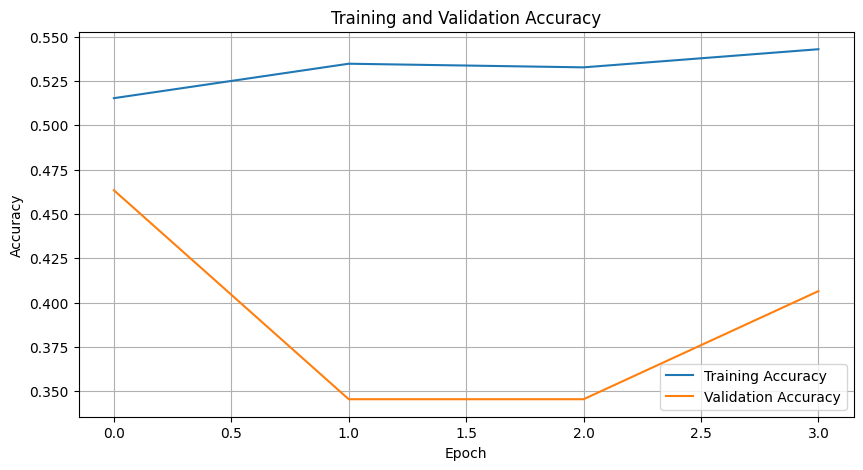

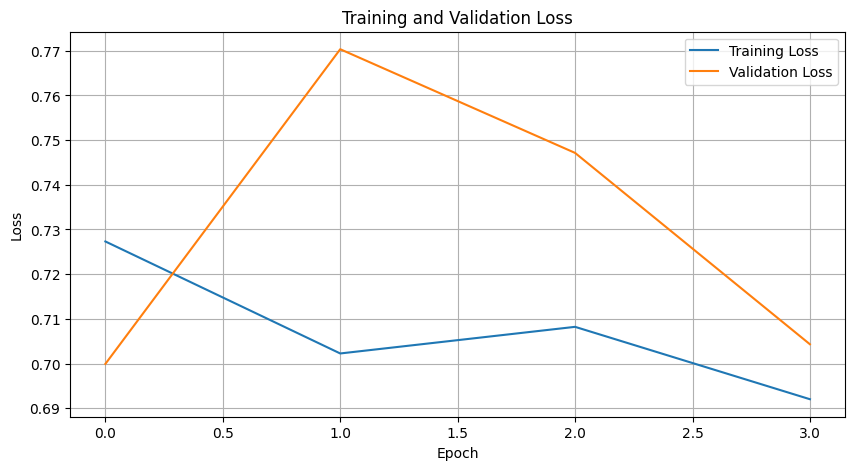

In [9]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()